# Stellargraph example: Graph Convolutional Network (GCN)

We demonstrated the use of GCN for node attribute inference on the CORA paper citation dataset.

Import NetworkX and stellar:

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

Using TensorFlow backend.


### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = os.path.expanduser("../data/cora")

Load the graph from edgelist

In [3]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [7]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [8]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=140, test_size=None, stratify=node_data['subject'])
val_data, test_data = model_selection.train_test_split(test_data, train_size=500, test_size=None, stratify=test_data['subject'])

Note using stratified sampling gives the following counts:

In [9]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Neural_Networks': 42,
         'Theory': 18,
         'Case_Based': 16,
         'Genetic_Algorithms': 22,
         'Reinforcement_Learning': 11,
         'Rule_Learning': 9,
         'Probabilistic_Methods': 22})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [10]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [11]:
node_features = node_data[feature_names]

In [12]:
node_features.head(3)

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1423,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creating the GCN model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [13]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [14]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a generator. Since GCN is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and graph adjacency matrix to the model.

In [15]:
generator = FullBatchNodeGenerator(G)

For training we map only the training nodes returned from our splitter and the target values.

In [16]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 32-dimensional hidden node features at the first layer and 7 for the second layer (output layer).
 * `activations` is a list of activations applied to each layer's output
 * Arguments such as `bias` and `dropout` are internal parameters of the model, execute `?GCN` for details. 

In [17]:
gcn = GCN(
    layer_sizes=[32, 7],
    generator=generator,
    bias=True,
    dropout=0.5,
    activations=["elu","softmax"],
)

In [18]:
# Expose the input and output tensors of the GCN model for node prediction, 
# via GCN.node_model() method:
x_inp, x_out = gcn.node_model()

Note that `x_inp` is a list of two input tensors, one for node features, the other for graph adjacency matrix

In [19]:
x_inp

[<tf.Tensor 'input_1:0' shape=(?, 1433) dtype=float32>,

Now we add the final layer to predict the 7 categories using Keras Dense layer with softmax activation.

In [20]:
# Snap the final estimator layer to x_out
#predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
predictions = x_out

In [21]:
predictions.shape

TensorShape([Dimension(None), Dimension(7)])

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [22]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    weighted_metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [23]:
val_gen = generator.flow(val_data.index, val_targets)

Create callbacks for early stopping (if validation accuracy stops improving) and best model checkpoint saving:

In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(monitor="val_weighted_acc", patience=50)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5",
    monitor="val_weighted_acc",
    save_best_only=True,
    save_weights_only=True,
)

Train the model

In [25]:
history = model.fit_generator(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/100
 - 1s - loss: 4.0373 - weighted_acc: 0.1143 - val_loss: 2.2597 - val_weighted_acc: 0.3900
Epoch 2/100
 - 0s - loss: 2.5342 - weighted_acc: 0.3214 - val_loss: 1.8589 - val_weighted_acc: 0.5580
Epoch 3/100
 - 0s - loss: 2.0875 - weighted_acc: 0.4571 - val_loss: 1.8016 - val_weighted_acc: 0.6100
Epoch 4/100
 - 0s - loss: 1.7483 - weighted_acc: 0.5357 - val_loss: 1.7067 - val_weighted_acc: 0.6620
Epoch 5/100
 - 0s - loss: 1.4361 - weighted_acc: 0.6429 - val_loss: 1.6110 - val_weighted_acc: 0.6960
Epoch 6/100
 - 0s - loss: 1.2267 - weighted_acc: 0.7214 - val_loss: 1.5311 - val_weighted_acc: 0.7280
Epoch 7/100
 - 0s - loss: 0.9355 - weighted_acc: 0.7857 - val_loss: 1.4650 - val_weighted_acc: 0.7360
Epoch 8/100
 - 0s - loss: 0.9317 - weighted_acc: 0.7500 - val_loss: 1.4006 - val_weighted_acc: 0.7460
Epoch 9/100
 - 0s - loss: 0.7147 - weighted_acc: 0.8214 - val_loss: 1.3383 - val_weighted_acc: 0.7480
Epoch 10/100
 - 0s - loss: 0.7128 - weighted_acc: 0.8143 - val_loss: 1.2511 - val_

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='right')
        plt.show()

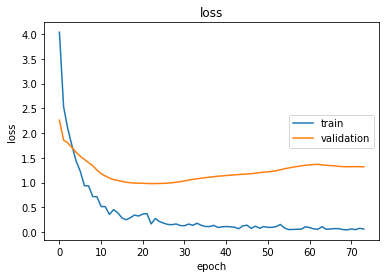

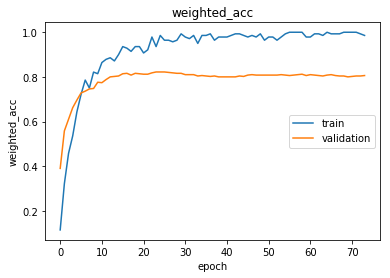

In [27]:
plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [28]:
model.load_weights("logs/best_model.h5")

Evaluate the best model on the test set

In [29]:
test_gen = generator.flow(test_data.index, test_targets)

In [30]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 1.0164
	weighted_acc: 0.8129


### Making predictions with the model

Now let's get the predictions themselves for all nodes:

In [31]:
all_nodes = node_data.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [32]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few (note that generator orders nodes according to the order in G.nodes(), so the predictions are ordered like that as well. We thus need to index results as `G.nodes()`

In [33]:
results = pd.DataFrame(node_predictions, index=G.nodes()).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(20)

,Predicted,True
35,subject=Genetic_Algorithms,Genetic_Algorithms
40,subject=Genetic_Algorithms,Genetic_Algorithms
114,subject=Reinforcement_Learning,Reinforcement_Learning
117,subject=Reinforcement_Learning,Reinforcement_Learning
128,subject=Reinforcement_Learning,Reinforcement_Learning
130,subject=Reinforcement_Learning,Reinforcement_Learning
164,subject=Theory,Theory
288,subject=Case_Based,Reinforcement_Learning
424,subject=Neural_Networks,Rule_Learning
434,subject=Reinforcement_Learning,Reinforcement_Learning


## Node embeddings
Evaluate node embeddings as activations of the output of GCN layer stack, and visualise them, coloring nodes by their subject label.

The GCN embeddings are the output of the GCN layers stack, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [34]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [35]:
emb = embedding_model.predict_generator(all_gen)
emb.shape

(2708, 7)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

Note that the generator orders nodes according to the order in G.nodes(), so we need to re-index node_data

In [37]:
X = emb
y = np.argmax(target_encoding.transform(node_data.reindex(G.nodes())[["subject"]].to_dict('records')), axis=1)

In [38]:
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

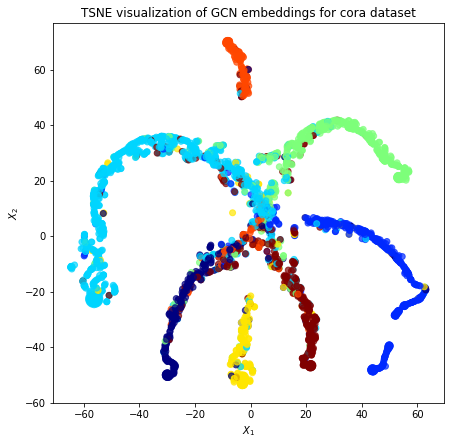

In [39]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GCN embeddings for cora dataset'.format(transform.__name__))
plt.show()